In [84]:
import os

from scipy.stats import ttest_ind
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pyometiff
import pandas as pd
import seaborn as sns

In [2]:
PATH_TO_FOLDER = os.path.join('..', 'd4l')
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')
# ORIGINAL_IMAGE_DATA_SUBDIR = 'images_masks'
# ORIGINAL_MASKS_SUBDIR = 'masks'
# ORIGINAL_IMAGES_SUBDIR = 'img'

if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
# TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
# TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
# TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

In [54]:
def normalize(expressions, scaling_factor=5):
    """
    Transform in CELESTA.ipynb
    
    Normalizes expression data using the arcsinh transformation.
    """
    expressions_transformed = np.arcsinh(expressions) / scaling_factor
    return expressions_transformed

def plot_marker_expressions(exp_df, markers):
    fig, axs = plt.subplots(len(markers), 1, figsize=(7, 5 * len(markers)))
    for i, gene in enumerate(markers):
        axs[i].hist(exp_df[gene], bins=100, color='r', alpha=0.5)
        axs[i].set_title(f'{gene} - Raw')
    plt.show()

def plot_cell_type_count(exp_df):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.hist(exp_df['celltypes'], bins=30, color='r', alpha=0.5)
    ax.set_title('Cell Type Count')
    plt.show()

def plot_marker_expression_range(exp_df, markers):
    """
    Plot the range of expression values for each marker gene. Scatter plot of the minimum and maximum expression values.
    """
    fig, axs = plt.subplots(len(markers), 1, figsize=(15, 5 * len(markers)))
    for i, marker in enumerate(markers):
        axs[i].scatter(exp_df['celltypes'], exp_df[marker], color='g', alpha=0.1)
        axs[i].set_title(f'{marker} - Expression Range')
    plt.show()

def plot_variance_of_markers(exp_df):
    """
    Plot the variance of each marker gene.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.bar(exp_df.columns, exp_df.var(), color='b', alpha=0.5)
    ax.set_title('Variance of Marker Genes')
    ax.set_xticklabels(exp_df.columns, rotation=90)
    plt.show()

def analyze_marker_expressions(exp_df, all_data_df, p_value_threshold=0.01):
    cell_types = all_data_df['celltypes'].unique()
    markers = exp_df.columns
    result = {}
    subjects = all_data_df['sample_id'].unique()
    

    for cell_type in cell_types:
        lower_markers = []
        higher_markers = []
        for subject in subjects:
            lower = set()
            higher = set()
            subject_df = all_data_df[all_data_df['sample_id'] == subject]
            for marker in markers:
                cell_type_expr = subject_df[subject_df['celltypes'] == cell_type][marker]
                other_cell_types_expr = subject_df[subject_df['celltypes'] != cell_type][marker]

                t_stat, p_value = ttest_ind(cell_type_expr, other_cell_types_expr)
                if p_value < p_value_threshold:
                    if cell_type_expr.mean() < other_cell_types_expr.mean():
                        lower.add(marker)
                    else:
                        higher.add(marker)
            lower_markers.append(lower)
            higher_markers.append(higher)
        result[cell_type] = {'lower': lower_markers, 'higher': higher_markers}

    return result

def get_significant_markers(marker_dict, all_data_df, threshold=0.8):
    """
    Get the markers that are present in cell types in at least 80% of subjects.
    """
    num_of_subjects = len(all_data_df['sample_id'].unique())
    result_dict = {}
    for cell_type, markers_sets in marker_dict.items():
        result_dict[cell_type] = {'lower' : [], 'higher' : []}
        for markers_set in markers_sets['lower']:
            result_dict[cell_type]['lower'] += markers_set
        for markers_set in markers_sets['higher']:
            result_dict[cell_type]['higher'] += markers_set

        result_dict[cell_type]['lower'] = [marker for marker in set(result_dict[cell_type]['lower']) if result_dict[cell_type]['lower'].count(marker) / num_of_subjects >= threshold]
        result_dict[cell_type]['higher'] = [marker for marker in set(result_dict[cell_type]['higher']) if result_dict[cell_type]['higher'].count(marker) / num_of_subjects >= threshold]
    return result_dict
        
def make_table_with_significant_markers(significant_markers_dict):
    all_markers = set()
    
    cell_types = significant_markers_dict.keys()
    for cell_type, markers_dict in significant_markers_dict.items():
        all_markers.update(markers_dict['lower'])
        all_markers.update(markers_dict['higher'])
    marker_to_level_dict = {marker: [] for marker in all_markers}
    for cell_type, markers_dict in significant_markers_dict.items():
        for marker in all_markers:
            if marker in markers_dict['lower']:
                marker_to_level_dict[marker].append('lower')
            elif marker in markers_dict['higher']:
                marker_to_level_dict[marker].append('higher')
            else:
                marker_to_level_dict[marker].append('none')        
    
    result_df = pd.DataFrame(marker_to_level_dict)
    result_df['celltype'] = cell_types
    result_df.set_index('celltype', inplace=True)

    return result_df

In [14]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)

In [15]:
markers = train_anndata.var['marker']
expressions_df = pd.DataFrame(train_anndata.layers["exprs"], columns=markers)
all_data = pd.concat([train_anndata.obs.reset_index(), expressions_df], axis=1)

In [16]:
print("There is a total of", len(all_data), "cells in the dataset.")

There is a total of 236791 cells in the dataset.


In [17]:
print("Minimal expression value: ", np.min(expressions_df.values))
print("Maximal expression value: ", np.max(expressions_df.values))
print("Mean expression value: ", np.mean(expressions_df.values))
print("Median expression value: ", np.median(expressions_df.values))
print("Maximal standard deviation of expression values: ", np.max(np.std(expressions_df.values, axis=0)))
print("Minimal standard deviation of expression values: ", np.min(np.std(expressions_df.values, axis=0)))

Minimal expression value:  0.0
Maximal expression value:  8.436070526198012
Mean expression value:  1.347737665027196
Median expression value:  0.914181447627153
Maximal standard deviation of expression values:  1.4945013816311672
Minimal standard deviation of expression values:  0.28289971656300267


There are only non-negative marker expression values.

The 'distToCells' column is the only one containing NaN values, with a total of 11829 NaN entries.

In [18]:
all_data['distToCells'].isnull().sum()

11829

# General data overview

The dataset provided includes spatial information at the individual cell level. It includes X and Y coordinates, along with marker levels acquired through the IMC method, as well as cell types.

In [19]:
print(f"Dataset has {len(all_data['image'].unique())} tissue images from {len(all_data['sample_id'].unique())} unique subjects.")
print(f"Dataset has {len(all_data['celltypes'].unique())} unique cell types:", ", ".join(list(all_data['celltypes'].unique())))
print(f"Each cell has {len(expressions_df.columns)} features (marker expressions):", ", ".join(list(expressions_df.columns)))

Dataset has 125 tissue images from 125 unique subjects.
Dataset has 15 unique cell types: MacCD163, Mural, DC, Tumor, CD4, HLADR, NK, CD8, Treg, Neutrophil, plasma, undefined, B, pDC, BnT
Each cell has 40 features (marker expressions): MPO, HistoneH3, SMA, CD16, CD38, HLADR, CD27, CD15, CD45RA, CD163, B2M, CD20, CD68, Ido1, CD3, LAG3, CD11c, PD1, PDGFRb, CD7, GrzB, PDL1, TCF7, CD45RO, FOXP3, ICOS, CD8a, CarbonicAnhydrase, CD33, Ki67, VISTA, CD40, CD4, CD14, Ecad, CD303, CD206, cleavedPARP, DNA1, DNA2


In [25]:
expressions_df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2'],
      dtype='object', name='marker')


Below we present distribution of normalized data for a couple of markers.

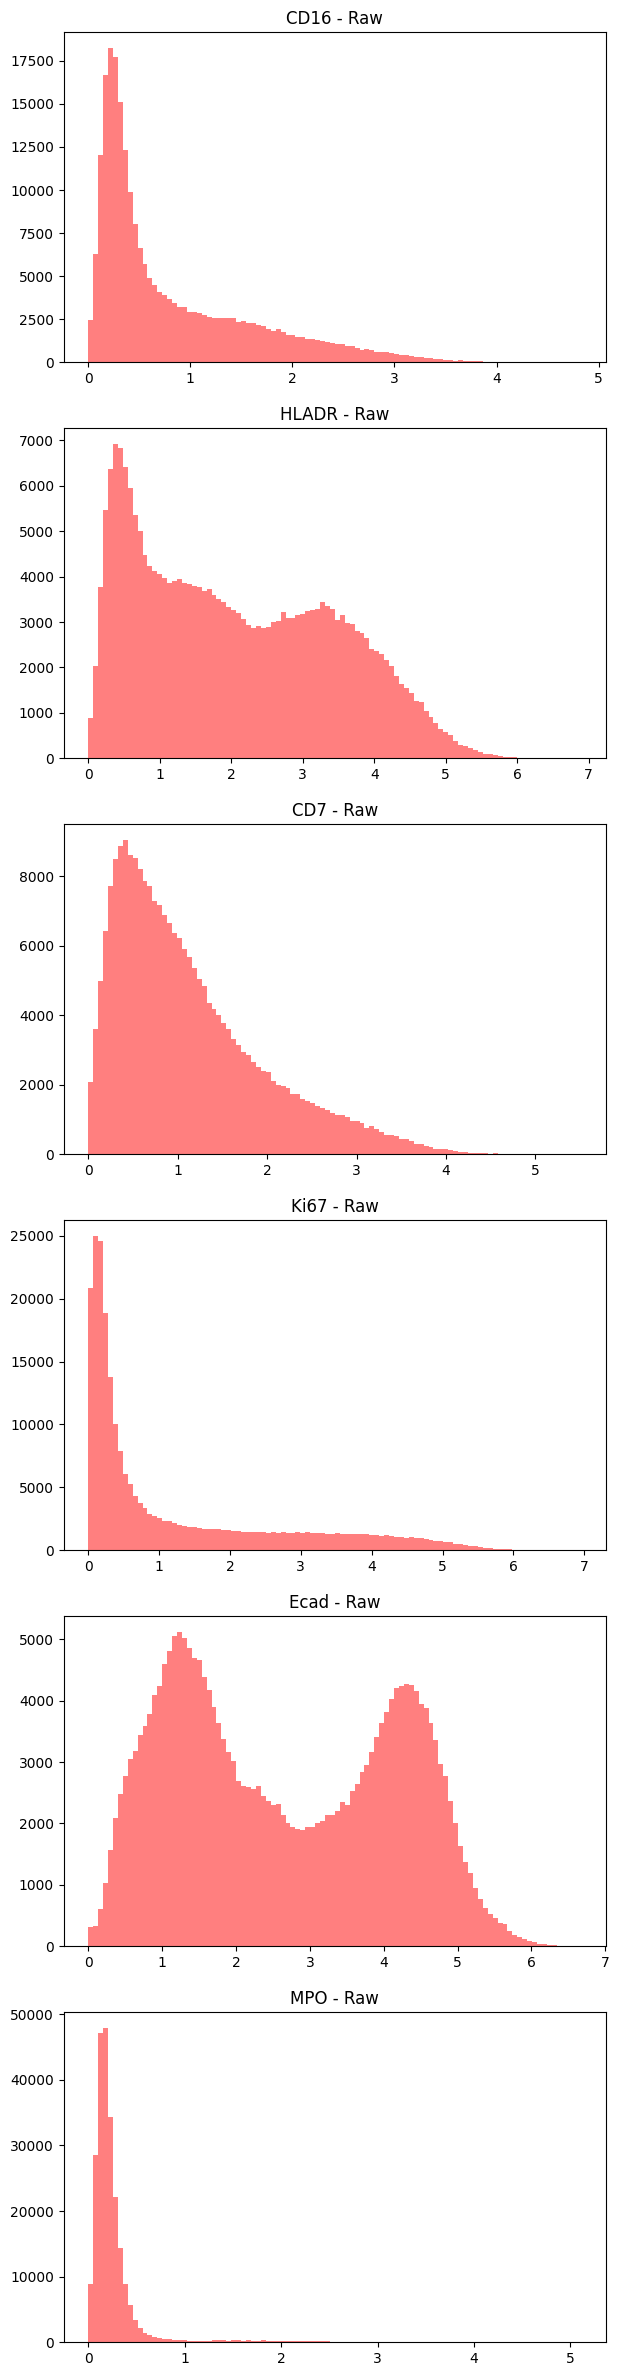

In [26]:
plot_marker_expressions(expressions_df, ['CD16', 'HLADR', 'CD7', 'Ki67', 'Ecad','MPO'])

Some markers display a bimodal distribution, featuring two distinct expression peaks. Others showcase a unimodal distribution with a narrower range of expression values across all cells, or a prominent single peak with the remaining values appearing relatively uniform. Additionally, some markers exhibit a somewhat normal distribution but may be skewed.

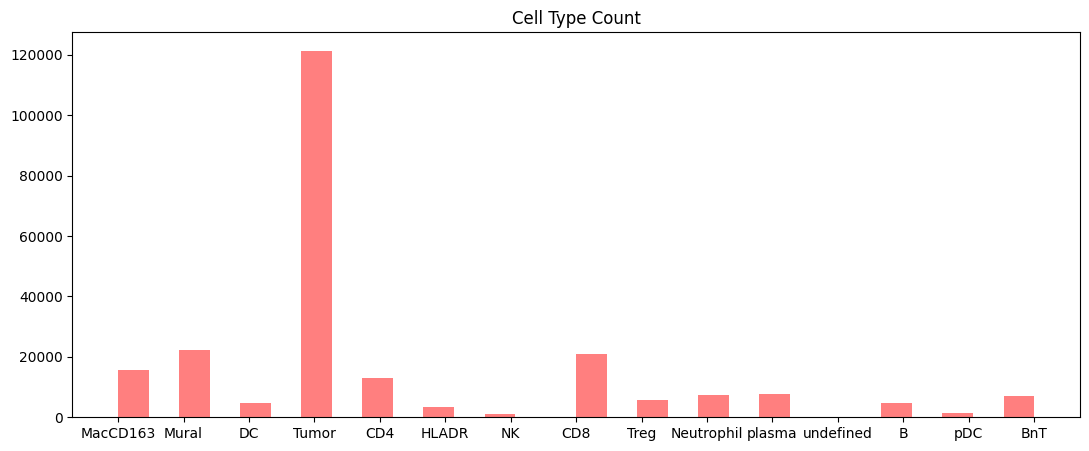

In [27]:
plot_cell_type_count(all_data)

As presented, there is a very significant prevalence of Tumor cells.

Markers exhibit varying levels across different cell types, and we illustrate these discrepancies for a selection of markers.

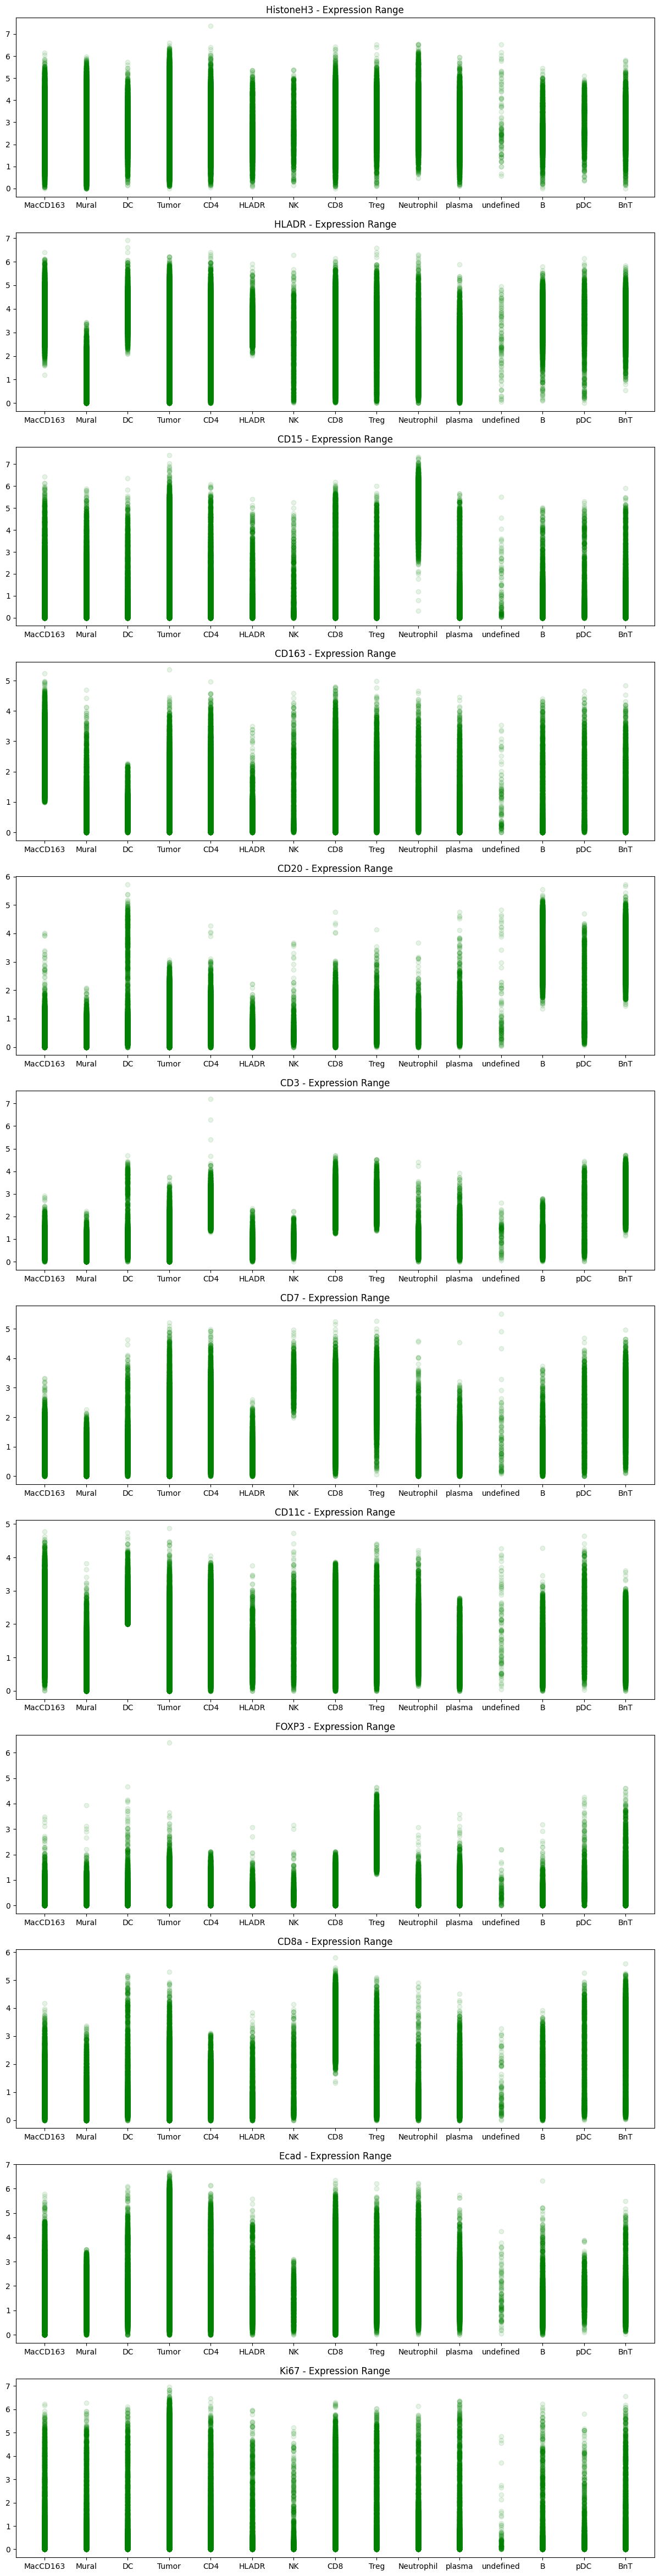

In [31]:
plot_marker_expression_range(all_data, ['HistoneH3', 'HLADR', 'CD15', 'CD163', 'CD20', 'CD3', 'CD7', 'CD11c', 'FOXP3', 'CD8a', 'Ecad', 'Ki67'])

/tmp/ipykernel_4356/1273896379.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(exp_df.columns, rotation=90)


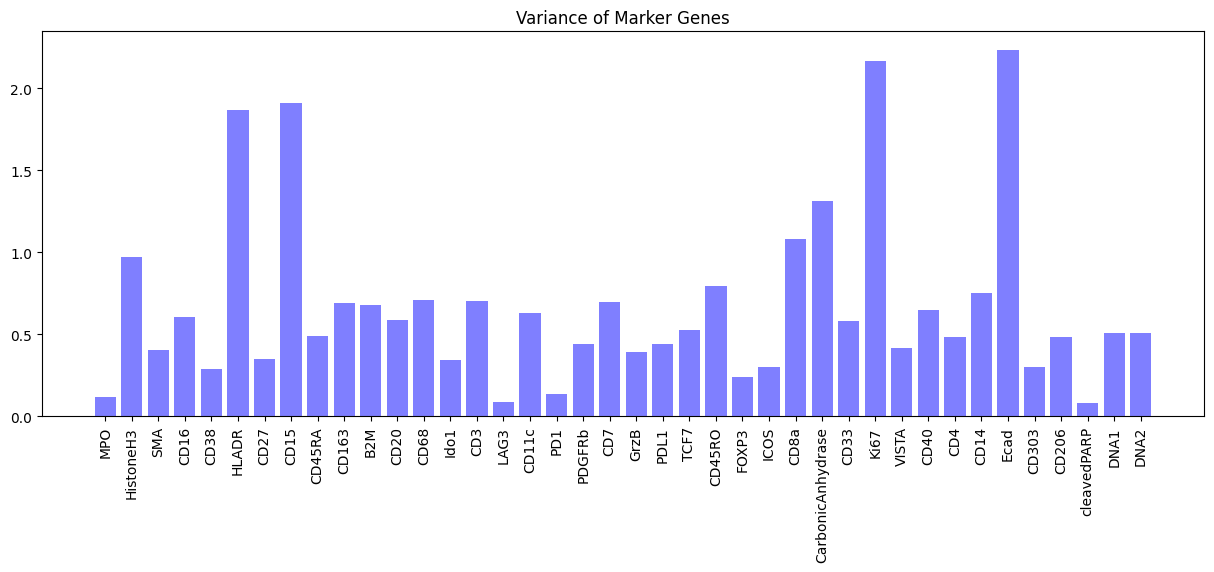

In [29]:
plot_variance_of_markers(expressions_df)

In [58]:
marker_expressions_levels = analyze_marker_expressions(expressions_df, all_data, p_value_threshold=0.01)

In [59]:
significant_markers = get_significant_markers(marker_expressions_levels, all_data, threshold=0.8)

In [60]:
cell_types = all_data['celltypes'].unique()

In [61]:
'. '.join(list(cell_types))

'MacCD163. Mural. DC. Tumor. CD4. HLADR. NK. CD8. Treg. Neutrophil. plasma. undefined. B. pDC. BnT'

In [62]:
significant_markers['Tumor']

{'lower': ['PDGFRb', 'CD68', 'CD45RO', 'CD16', 'CD163', 'VISTA', 'SMA'],
 'higher': ['Ecad', 'CarbonicAnhydrase']}

In [63]:
markers_signature_df = make_table_with_significant_markers(significant_markers)

In [78]:
MARKERS_RELATIVE_LEVELS_DF_FILE = 'markers_levels_in_cell_types.csv'
#markers_signature_df.to_csv('markers_levels_in_cell_types.csv')
markers_signature_df = pd.read_csv(MARKERS_RELATIVE_LEVELS_DF_FILE)
markers_signature_df.set_index('celltype', inplace=True)

In [66]:
markers_signature_df.head()

,celltype,HLADR,HistoneH3,CD11c,CD15,CD4,PDL1,CD20,LAG3,PDGFRb,...,CD38,cleavedPARP,CD27,CD8a,FOXP3,SMA,CarbonicAnhydrase,CD7,PD1,CD14
0,MacCD163,higher,none,higher,none,higher,none,none,none,none,...,none,none,none,none,none,none,none,none,none,higher
1,Mural,lower,lower,lower,lower,lower,lower,lower,lower,higher,...,lower,lower,lower,lower,lower,higher,lower,lower,lower,none
2,DC,higher,none,higher,none,none,none,none,none,none,...,none,none,none,none,none,none,none,none,none,none
3,Tumor,none,none,none,none,none,none,none,none,lower,...,none,none,none,none,none,lower,higher,none,none,none
4,CD4,none,none,none,none,higher,none,none,none,none,...,none,none,none,none,none,none,none,none,none,none


## Cell types and markers correlation

Our objective was to examine the markers exhibiting significantly higher or lower levels across all cell types. To achieve this, we conducted T-tests comparing the means of marker levels for a specific cell type against the means of marker levels for the remaining cell types. Additionally, T-tests were performed for each Region of Interest (ROI) individually to ensure that any differences in marker level distributions were not confounded by potential batch effects.

We set the significance threshold at a p-value of 0.01 and identified sets of markers that were significantly higher or lower for each ROI and each cell type. We considered the results reliable if a particular marker showed a significant difference in at least 80% of the ROI.

The results are documented in the 'markers_levels_in_cell_types.csv' file, and we highlight a selection of biologically intriguing findings below.

In [79]:
cell_types_subset = ['Tumor', 'Mural', 'DC', 'MacCD163', 'CD4', 'CD8']
markers_subset = ['HLADR', 'CD8a', 'HistoneH3', 'CD11c', 'CD4', 'PDGFRb', 'Ecad', 'CD3', 'ICOS']
sub_signature_df = markers_signature_df.loc[cell_types_subset, markers_subset]

In [80]:
sub_signature_df

,HLADR,CD8a,HistoneH3,CD11c,CD4,PDGFRb,Ecad,CD3,ICOS
celltype,,,,,,,,,
Tumor,none,none,none,none,none,lower,higher,none,none
Mural,lower,lower,lower,lower,lower,higher,lower,lower,lower
DC,higher,none,none,higher,none,none,none,none,none
MacCD163,higher,none,none,higher,higher,none,lower,none,none
CD4,none,none,none,none,higher,none,lower,higher,none
CD8,none,higher,none,none,none,none,none,higher,none


## Biological explanation
* High expression of Ecan on Tumor cells

* High expression of HLADR on Macrophages and Dendritic cells

* High expression of CD11c on Dendritic cells

* High expression of CD4 in CD4 T cells

* Low expression of Histone H3 in Mural cells

* Low expression of ICOS in Mural cells

* High expression of SMA in Mural cells

* High expression of CD11c on Marcophages and Dentritic cells

* High expression of CD8a on CD8 T cells

* High expression of CD3 on T cells

* High expression of Carbonic Anhydrase in Tumor cells

* High expression of CD68 on Macrophages



## Co-expression of markers

In [81]:
markers_corr = expressions_df.corr()

<Axes: xlabel='marker', ylabel='marker'>

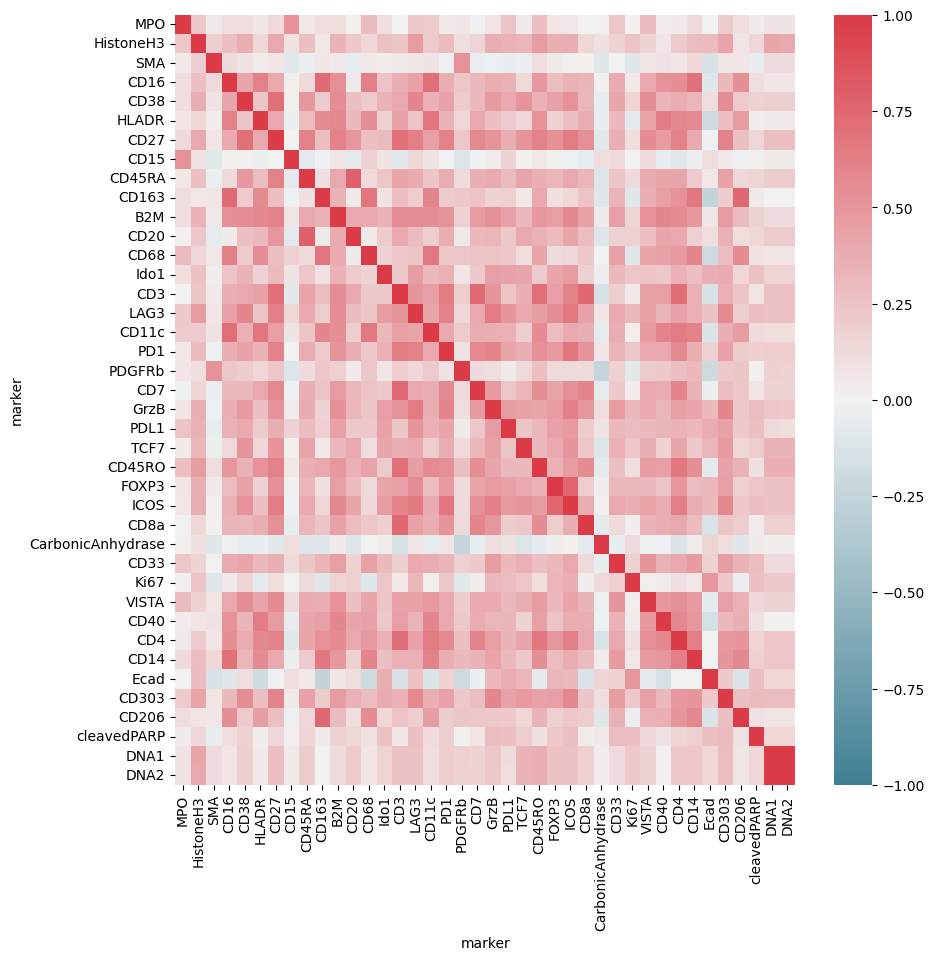

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr.columns.values,
            yticklabels=markers_corr.columns.values,
            ax=ax)